In [1]:
from ecnet.datasets import load_cn
from ecnet.tasks.feature_selection import select_rfr
from ecnet import ECNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import median_absolute_error, r2_score
import torch
import numpy as np
from matplotlib import pyplot as plt
from copy import deepcopy

In [2]:
dataset = load_cn(as_dataset=True, backend='alvadesc')
print(dataset.desc_vals.shape, dataset.target_vals.shape)

torch.Size([460, 5305]) torch.Size([460, 1])


In [3]:
index_train, index_test = train_test_split([i for i in range(len(dataset))],
                                           test_size=0.2, random_state=42)
dataset_train = deepcopy(dataset)
dataset_train.set_index(index_train)
dataset_test = deepcopy(dataset)
dataset_test.set_index(index_test)
print(dataset_train.desc_vals.shape, dataset_test.desc_vals.shape)

torch.Size([368, 5305]) torch.Size([92, 5305])


In [4]:
desc_idx, desc_imp = select_rfr(dataset_train, total_importance=0.95,
                                n_estimators=100, n_jobs=4)
dataset_train.set_desc_index(desc_idx)
dataset_test.set_desc_index(desc_idx)
desc_names = [dataset.desc_names[i] for i in desc_idx]
print(dataset_train.desc_vals.shape, dataset_test.desc_vals.shape)
print(desc_names[:5], len(desc_names))
print(desc_imp[:5])
with open('_models/cn_desc.txt', 'w') as txt_file:
    txt_file.writelines([str(i) + '\n' for i in desc_idx])
txt_file.close()

torch.Size([368, 327]) torch.Size([92, 327])
['SpMaxA_EA(ed)', 'CIC1', 'S3K', 'PHI', 'SssCH2'] 327
[0.13338397374049082, 0.0997655636261512, 0.06332580504251639, 0.061758241155556476, 0.04915629126418372]


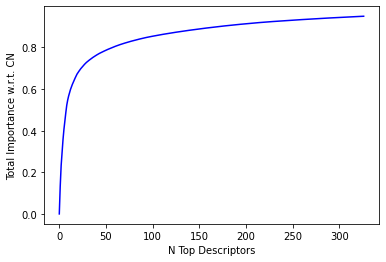

In [5]:
plt.clf()
x_vals = [i for i in range(len(desc_imp))]
y_vals = [0.0]
for idx in range(len(desc_imp) - 1):
    y_vals.append(sum(desc_imp[:idx + 1]))
plt.xlabel('N Top Descriptors')
plt.ylabel('Total Importance w.r.t. CN')
plt.plot(x_vals, y_vals, color='blue')
plt.show()

In [6]:
model = ECNet(dataset_train.desc_vals.shape[1], dataset_train.target_vals.shape[1],
              64, 1)
train_loss, valid_loss = model.fit(
    dataset=dataset_train, valid_size=0.2, verbose=10,
    patience=50, epochs=300, random_state=12, lr=0.001, lr_decay=1e-8
)

Epoch: 0 | Train loss: 1962.0704735995962 | Valid loss: 9223372036854775807
Epoch: 10 | Train loss: 292.37299404014533 | Valid loss: 255.67398071289062
Epoch: 20 | Train loss: 187.51559749265917 | Valid loss: 127.6782455444336
Epoch: 30 | Train loss: 151.86449193630088 | Valid loss: 111.49929809570312
Epoch: 40 | Train loss: 133.03333323991217 | Valid loss: 123.8625259399414
Epoch: 50 | Train loss: 127.77541525185514 | Valid loss: 107.9894027709961
Epoch: 60 | Train loss: 113.98478184914103 | Valid loss: 112.77896881103516
Epoch: 70 | Train loss: 104.14021903316991 | Valid loss: 88.53089141845703
Epoch: 80 | Train loss: 97.25696345738002 | Valid loss: 84.0439453125
Epoch: 90 | Train loss: 97.83242870512463 | Valid loss: 86.7278823852539
Epoch: 100 | Train loss: 80.26344649645748 | Valid loss: 118.79821014404297
Epoch: 110 | Train loss: 71.97126117368944 | Valid loss: 75.98859405517578
Epoch: 120 | Train loss: 65.0922099522182 | Valid loss: 74.40974426269531
Epoch: 130 | Train loss: 69.

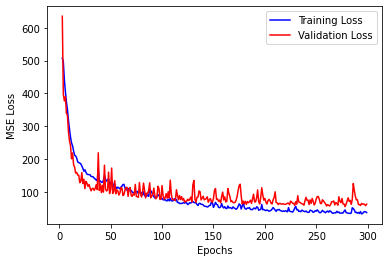

In [7]:
plt.clf()
train_loss = train_loss[3:]
valid_loss = valid_loss[3:]
epoch = [i for i in range(3, len(train_loss) + 3)]
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.plot(epoch, train_loss, color='blue', label='Training Loss')
plt.plot(epoch, valid_loss, color='red', label='Validation Loss')
plt.legend(loc='upper right')
plt.show()

In [8]:
y_hat_train = model(dataset_train.desc_vals).detach().numpy()
y_train = dataset_train.target_vals.numpy()
y_hat_test = model(dataset_test.desc_vals).detach().numpy()
y_test = dataset_test.target_vals.numpy()

mae_train = median_absolute_error(y_hat_train, y_train)
mae_test = median_absolute_error(y_hat_test, y_test)
r2_train = r2_score(y_hat_train, y_train)
r2_test = r2_score(y_hat_test, y_test)
print(f'Training set: {mae_train} | {r2_train}')
print(f'Testing set: {mae_test} | {r2_test}')

Training set: 2.9622983932495117 | 0.9418648845915659
Testing set: 6.205254554748535 | 0.8681760669225826


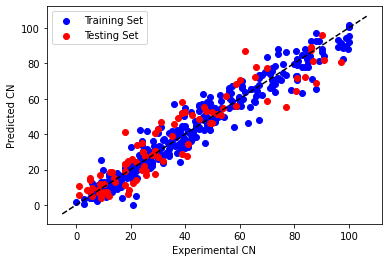

In [9]:
min_val = min(min(y_hat_train), min(y_train)) - 0.05 * max(max(y_hat_train), max(y_train))
max_val = max(max(y_hat_train), max(y_train)) + 0.05 * max(max(y_hat_train), max(y_train))
plt.clf()
plt.xlabel('Experimental CN')
plt.ylabel('Predicted CN')
plt.plot([min_val, max_val], [min_val, max_val], 'k--')
plt.scatter(y_train, y_hat_train, color='blue', label='Training Set')
plt.scatter(y_test, y_hat_test, color='red', label='Testing Set')
plt.legend(loc='upper left')
plt.show()

In [10]:
model.save('_models/cn.pt')